In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import tensorflow as tf
import heartpy as hp
import pandas as pd
import numpy as np 
import pywt as pw
import openpyxl
import pickle
import tsfel
import json

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

2023-11-16 01:40:35.986712: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 01:40:36.006525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 01:40:36.006552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 01:40:36.006564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 01:40:36.011031: I tensorflow/core/platform/cpu_feature_g

# Functions 

In [2]:
num_of_participants = 23
num_of_clips = 18

#In Hz:
cutoff = [0.5, 45]
sample_rate = 256.0
order = 3
filtertype ='bandpass'
def data_filter (data):
    # Separate data by channel
    for participant in data.keys():
        #print("Starting " + participant)
        for clip_num in range(0, num_of_clips):
            # Filter both channels from baseline
            CH1 = [row[0] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            s_clip = "clip " + str(clip_num+1) 

            data[participant]['ECG'][s_clip] = {}
            data[participant]['ECG'][s_clip]['CH1'] = {}
            data[participant]['ECG'][s_clip]['CH1']['baseline'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2'] = {}
            data[participant]['ECG'][s_clip]['CH2']['baseline'] = CH2_filtered.tolist()

            
            # Filter both channels from stimuli
            CH1 = [row[0] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH1_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            CH2 = [row[1] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            # CH2_filtered = hp.butter_lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate, order=order)

            data[participant]['ECG'][s_clip]['CH1']['stimuli'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2']['stimuli'] = CH2_filtered.tolist()

            data[participant]['ECG'][s_clip]['ScoreValence'] = data[participant]['ScoreValence'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreArousal'] = data[participant]['ScoreArousal'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreDominance'] = data[participant]['ScoreDominance'][clip_num]
            
            print("Done filtering raw for " + participant + " at clip#" + str(clip_num+1) + "                 ", end="\r", flush=True)
        data[participant]['ECG'].pop('stimuli')
        data[participant]['ECG'].pop('baseline')

        data[participant].pop('ScoreValence')
        data[participant].pop('ScoreArousal')
        data[participant].pop('ScoreDominance')
    
    print("All done.... Highpass filter applied, cutoff: [" + str(cutoff[0]) + "," + str(cutoff[1]) + "]Hz")
    return data
            
            
### Function to display graph
def show_graph(participant, clip, dtype, range_min = 0, range_max = -1):
    plt.plot(filtered_data[participant]['ECG'][dtype][clip][range_min:range_max])
    plt.ylabel("mV")
    plt.xlabel("Sample #")
    graph_title = participant + "  clip#" + str(clip) + " " + dtype + " data range: " + str(range_min) + " => " + str(range_max)
    plt.title(graph_title)

### Function to split channels
def chan_split(filtered_data, participant, clip, dtype):
    ch1 = [row[0] for row in filtered_data[participant]['ECG'][dtype][clip]]
    ch2 = [row[1] for row in filtered_data[participant]['ECG'][dtype][clip]]
    
    return ch1, ch2


### Function to plot Heard Rate Signal Peak Detection
def peak_detection(participant, clip, dtype, ch = 1, range_min = 0, range_max = -1):
    
    p1_c1_ch1, p1_c1_ch2 =(chan_split(participant, clip, dtype))
    wd1 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    wd2 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    if ch == 1:
        hp.plotter(wd1[0], wd1[1])
    else:
        hp.plotter(wd2[0], wd2[1])

def extract_time_domain_as_pd_df(processed_data):
    combined_data = pd.DataFrame()
    cfg = tsfel.get_features_by_domain()
    for CH in ['CH1', 'CH2']:
        for participant in processed_data:
            for clip in processed_data[participant]['ECG']:
                data_size = len(processed_data[participant]['ECG'][clip][CH]['stimuli'])
                for_iterations = windows_size % data_size
                for i in range(0, data_size, windows_size):
                    print("Processing " + participant + " " + clip + " " + CH + " window:" + str(int(i/windows_size)) + "/" + str(int(data_size/windows_size)) + "          ", end="\r", flush=True)
                    features_df = pd.DataFrame()
                    features_df = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip][CH]['stimuli'][i:i+windows_size], verbose=False)
                    features_df['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
                    features_df['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
                    features_df['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']
                
                    combined_data = pd.concat([combined_data, features_df], ignore_index=True)
                
                    # print("Done with time features for participant ", participant, " clip ", clip)
    print()
    print("Done extracting time domain features")
    return combined_data

def extract_ecg_features(processed_data):
    combined_data = pd.DataFrame()
    for CH in ['CH1', 'CH2']:
        for participant in processed_data:
            for clip in processed_data[participant]['ECG']:
                print("Processing " + participant + " " + clip + " " + CH + "          ", end="\r", flush=True)
                features_df = pd.DataFrame()
                hp_tupple = hp.process(processed_data[participant]['ECG'][clip][CH]['stimuli'], 256)
                features_df = pd.DataFrame([hp_tupple[1]])
                features_df['ScoreValence'] = processed_data[participant]['ECG'][clip]['ScoreValence']
                features_df['ScoreArousal'] = processed_data[participant]['ECG'][clip]['ScoreArousal']
                features_df['ScoreDominance'] = processed_data[participant]['ECG'][clip]['ScoreDominance']
            
                combined_data = pd.concat([combined_data, features_df], ignore_index=True)
            
                # print("Done with time features for participant ", participant, " clip ", clip)
    print()
    print("Done extracting time domain features")
    return combined_data
            

# Code

## Load & Process RAW Data, then create and save processed data to .pkl

All done.... Highpass filter applied, cutoff: [0.5,45]Hz         


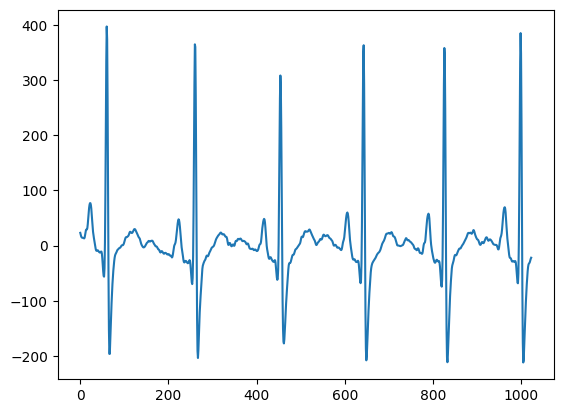

In [3]:
raw_data = {}
load_raw_from = '../data_set_raw_ECG/raw_data_dict.pkl'

with open(load_raw_from, 'rb') as f:
    raw_data = pickle.load(f)

filtered_data = data_filter(raw_data)

plt.plot(filtered_data['participant_1']['ECG']['clip 1']['CH1']['stimuli'][0:1024])

In [4]:
basic_features = extract_ecg_features(filtered_data)

/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Processing participant_9 clip 18 CH2           
Done extracting time domain features


In [5]:
basic_features

bpm         ibi       sdnn       sdsd      rmssd     pnn20  \
0    81.279433  738.194122  42.396538  16.626440  25.494683  0.358209   
1    77.943791  769.785503  57.088408  19.262788  30.843360  0.446429   
2    77.092988  778.280900  53.698660  21.945741  32.943804  0.467416   
3    74.404537  806.402439  47.537625  18.382144  30.377339  0.465686   
4    80.525996  745.101001  37.397967  17.250024  25.766778  0.355556   
..         ...         ...        ...        ...        ...       ...   
823  69.600277  862.065529  27.074820  12.785315  23.360584  0.420513   
824  68.829820  871.715199  40.928387  14.654194  25.072095  0.424501   
825  69.802670  859.565972  38.248872  15.151408  22.930660  0.339286   
826  73.333129  818.184095  34.542539  10.383782  17.233170  0.228296   
827  69.032244  869.159051  34.236229  13.604447  23.984955  0.421801   

        pnn50     hr_mad        sd1        sd2            s   sd1/sd2  \
0    0.048507  27.343750  18.027039  57.239628  3241.686952  0.314940   
1    0.113095  31.250000  21.809524  77.785344  5329.590411  0.280381   
2    0.130337  37.109375  23.294092  72.266660  5288.513738  0.322335   
3    0.112745  31.250000  21.470594  62.925427  4244.437102  0.341207   
4    0.066667  23.437500  18.219631  49.555481  2836.489310  0.367661   
..        ...        ...        ...        ...          ...       ...   
823  0.020513  19.531250  16.517820  33.956265  1762.067424  0.486444   
824  0.039886  23.437500  17.728641  55.108754  3069.346484  0.321703   
825  0.022321  23.437500  16.212732  51.153961  2605.465602  0.316940   
826  0.003215  19.531250  12.185300  47.270861  1809.587565  0.257776   
827  0.028436  23.437500  16.959919  45.393210  2418.602728  0.373622   

     breathingrate  ScoreValence  ScoreArousal  ScoreDominance  
0         0.100000             4             3               2  
1         0.133333             3             3               1  
2         0.288276             5             4               4  
3         0.133333             4             3               2  
4         0.166667             4             4               4  
..             ...           ...           ...             ...  
823       0.300000             3             3               3  
824       0.293466             3             4               4  
825       0.100000             4             4               4  
826       0.300000             2             4               4  
827       0.266667             3             4               4  

[828 rows x 16 columns]

In [6]:
X = basic_features.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = basic_features[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

In [7]:
# Train the SVM
svm_rbf_model = SVC(kernel='rbf', C=100, gamma=1)  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_rbf_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.7530120481927711
Accuracy for Arousal: 0.7710843373493976
Accuracy for Dominance: 0.8253012048192772


# THIS IS A GOOD OPTION TOO ^^^

In [8]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-Output SVM Classifier
# Best parameters: {'estimator__C': 100, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'}
svm_rbf_model = SVC(kernel='rbf', C=100, gamma=1)  # Base SVM model
multi_target_svm = MultiOutputClassifier(svm_rbf_model)  # Multi-output wrapper

# Training
multi_target_svm.fit(X_train_scaled, Y_train)

# Predictions
y_pred = multi_target_svm.predict(X_test_scaled)

# Evaluation
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    print(f"Classification Report for {target}:")
    print(classification_report(Y_test.iloc[:, i], y_pred[:, i]))

# Grid Search (Note: This is tricky with multi-output classifiers)
# For simplicity, the following code is a template for a single-output grid search
param_grid = {
    'estimator__C': [0.1, 1, 10, 100],  # Note the 'estimator__' prefix
    'estimator__gamma': [1, 0.1, 0.01, 0.001],
    'estimator__kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(MultiOutputClassifier(SVC()), param_grid, refit=True, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Classification Report for Valence:
              precision    recall  f1-score   support

           1       0.73      0.86      0.79        28
           2       0.64      0.64      0.64        36
           3       0.70      0.74      0.72        31
           4       0.95      0.76      0.84        50
           5       0.71      0.81      0.76        21

    accuracy                           0.75       166
   macro avg       0.74      0.76      0.75       166
weighted avg       0.77      0.75      0.76       166

Classification Report for Arousal:
              precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.79      0.74      0.76        35
           3       0.65      0.82      0.72        38
           4       0.86      0.79      0.82        61
           5       0.78      0.64      0.70        22

    accuracy                           0.77       166
   macro avg       0.78      0.78      0.77       166
weighte